# ROC curve computing with Error Bars

## This Notebook aims to show the development of the routine

### Overview

1. Create a baseline example
2. Compute the ROC using a standar package from `sklearn`
3. Develop the costume rutine using `ROOT` objects
4. Compute the ROC using the costume rutine and compare the results.

In [1]:
# -- Necessary dependencies
import numpy as np
import ROOT as r
# -- other packages
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

Welcome to JupyROOT 6.22/02


## Baseline from a Uniform distribution

We create two arrays:
 - Y_True : the true expected values, it only holds 2 posible values {0;1}.
 - Y_Pred : the predicted values for the respective entry of Y_True, it is a float between [0;1]

In [2]:
# -- Def Baseline arrs
Y_True = np.random.randint(2,size=1000)
Y_Pred = np.random.rand(1000)

## Compute ROC using `sklearn.metrics.roc_curve`

This method will return 3 arrays:
 - `fpr` : False-Positive-Rate which is equal to:
 >$
 \begin{equation*}
     fpr = \frac{TN}{TN+FP} 
 \end{equation*}
 $
 
 - `tpr` : True-Positive-Rate which is equal to:
>$
 \begin{equation*}
     tpr = \frac{TP}{TP+FN} 
 \end{equation*}
 $
 
 - `threshold`: array of floats to determine $TP$ and $TN$ from the `Y_Pred`.


### How does it work?



In [3]:
fpr,tpr, trh = roc_curve(y_true=Y_True, y_score=Y_Pred)

No handles with labels found to put in legend.


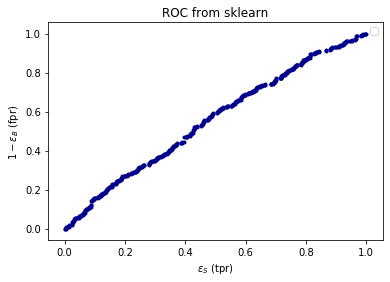

In [4]:
# -- Plot results
fig, ax = plt.subplots()
ax.scatter(x=tpr, y=fpr, color='DarkBlue',marker='.')
ax.set_xlabel(r'$\epsilon_S$ (tpr)')
ax.set_ylabel(r'$1 - \epsilon_B$ (fpr)')
ax.set_title('ROC from sklearn')
ax.legend()
plt.show()

## Compute the ROC and its Errors using ROOT Objects

1. Compute Signal and Background efficiencies:
    > 
    $
    \begin{align*}
    \epsilon_S 
        &= \frac{N^S_p(\tau)}{N^S_T} \\
        &= \frac{TP}{TP+FN}
    \end{align*}
    $ 
    
    >
    $
    \begin{align*}
    \epsilon_B 
        &= \frac{N^B_p(\tau)}{N^B_T} \\
        &= \frac{TN}{TN+FP}
    \end{align*}
    $
    
    where $N^B_T = N^S_F$, 
    and $\tau$ is a parameter of the treshold.
    
    *Note* this are equivalent to `tpr` and `fpr` respectively.
    
2. Then Background Rejection will be $1 - \epsilon_B$.

3. To compute each $N$ we use an auxiliary 1-Bin histogram, from which we can use the `TGraphAsymmErrors.Divide` method to get the uncertainties for each point. There are many options to choose from, but according to [Lawrence D. Brow, et.al](http://www-stat.wharton.upenn.edu/~tcai/paper/Binomial-StatSci.pdf) we are implementing the Bayesian way

In [5]:
def Fill_histo_YTrue(y_true, h_NS, h_NB):
    """
    Fills the given ROOT.THF1 histograms with the True values of the Signal and the Background.
    This is the same as (TP+FN) for Signal, and (TN+FP) for Background.
    
    # Args:
        
        y_true: (array) contains true values either {0;1}.
        
        h_NS: (ROOT.THF1) auxiliary histogram to count true signal entries (TP+FN).
        
        h_NB: (ROOT.THF1) auxiliary histogram to count true background entries (TN+FP).
    
    # Returns: None
    """
    for elem in y_true:
        if elem:
            h_NS.Fill(elem)
        elif elem is not None:
            h_NB.Fill(elem)            

In [6]:
def Fill_histo_YPred(y_pred, y_true, thr, h_NSPred, h_NBPred):
    """
    Fills the given ROOT.THF1 histograms with the predicted TP and TN values for Signal and Background respectively.
    At each threshold we evaluate if the prediction is equal to the expected value, if so we fill the corresponding histogram.
    
    # Args:
        
        y_true: (array) contains true values either {0;1}.
        
        y_pred: (array) contains predicted values floats in [0.;1.].
        
        h_NSPred: (ROOT.THF1) auxiliary histogram to count true predicted signal entries TP.
        
        h_NBPred: (ROOT.THF1) auxiliary histogram to count true predicted background entries TN.
    
    # Returns: None
    """
    for j, elem in enumerate(y_pred):
        # -- fill TP from predicted
        if elem > thr and y_true[j]:
            h_NSPred.Fill(elem)
        # -- fill TN from predicted
        elif elem <= thr and not y_true[j]:
            h_NBPred.Fill(elem)

In [7]:
            
def Compute_ROC(y_true, y_pred, threshold=None):
    """
    For each threshold it fills two auxiliary histograms to copmute TP and TN.
    It later uses this histograms together with the previously calculated (TP+FN) and (TN+FP) histograms,
    through a Divede method that returns the Signal (Background) efficiency with its uncertainty, respectively.
    As default this uncertainties are computing using a Bayesian approach with a Beta(0.5,0.5) prior.
    
    # Args:
    
    # Returns:
        
        sig_eff_arr: (list) this container holds 3 numpy arrays
            - EffS_arr: the computed efficiency for the Signal.
            - EffS_Errlow_arr: the lower bound of the computed uncertainty.
            - EffS_Errhigh_arr: the upper bound of the computed uncertainty.
        bkg_eff_arr: (list) this container holds 3 numpy arrays
            - EffB_arr: the computed efficiency for the Signal.
            - EffB_Errlow_arr: the lower bound of the computed uncertainty.
            - EffB_Errhigh_arr: the upper bound of the computed uncertainty.
        threshold: (NumpyArray) the thresholds array if it was not provided.
    """
    # -- def outputs
    sig_eff_arr = []
    bkg_eff_arr = []
    if threshold is None:
        threshold = np.linspace(start=0,stop=1,num=50)
    
    # -- def aux containers
    EffS_arr, EffS_Errlow_arr, EffS_Errhigh_arr = [], [], []
    EffB_arr, EffB_Errlow_arr, EffB_Errhigh_arr = [], [], []
    
    # -- def aux histograms
    h_NSig = r.TH1F('TrueSig','TrueSig',1,0.,1.1)
    h_NBkg = r.TH1F('TrueBkg','TrueBkg',1,0.,1.1)
    h_NPredSig = r.TH1F('PredSig','PredSig',1,0.,1.1)
    h_NPredBkg = r.TH1F('PredBkg','PredBkg',1,0.,1.1)
    
    # -- def aux graph error var to compute the errors from histograms
    eff_Sig = r.TGraphAsymmErrors()   
    eff_Bkg = r.TGraphAsymmErrors()

    
    # -- fill denominators
    Fill_histo_YTrue(y_true=y_true, h_NS=h_NSig, h_NB=h_NBkg)
    
#     print(f'DenS len: {h_NSig.GetEntries()}')
#     print(f'DenB len: {h_NBkg.GetEntries()}')
#     print()
    
    assert all(threshold) <= 1.
    for thr in threshold:
        # --clean histograms
        h_NPredSig.Reset()
        h_NPredBkg.Reset()
        # -- fill numerators
        Fill_histo_YPred(y_pred=y_pred,
                         y_true=y_true,
                         thr=thr,
                         h_NBPred=h_NPredBkg,
                         h_NSPred=h_NPredSig
                        )
        # -- checking --
#         print(f'Spred len: {h_NPredSig.GetEntries()}')
#         print(f'Bpred len:  {h_NPredBkg.GetEntries()}')
        
        # -- compute the eff with errors
        eff_Sig.Divide(h_NPredSig, h_NSig, 'cl=0.683 b(0.5,0.5) mode')
        eff_Bkg.Divide(h_NPredBkg, h_NBkg, 'cl=0.683 b(0.5,0.5) mode')
        
        # -- append to containers
        # -- the coord x of the .Divide method is the bin center so we don't need it
        # -- the eff is the y coord of the .Dived method
        # -- NOTE: we only need the first element since there is only 1 bin.
        EffS_arr.append(eff_Sig.GetPointY(0)) 
        EffS_Errlow_arr.append(eff_Sig.GetErrorYlow(0))
        EffS_Errhigh_arr.append(eff_Sig.GetErrorYhigh(0))
        
        EffB_arr.append(eff_Bkg.GetPointY(0)) 
        EffB_Errlow_arr.append(eff_Bkg.GetErrorYlow(0))
        EffB_Errhigh_arr.append(eff_Bkg.GetErrorYhigh(0))

    sig_eff_arr = [np.asarray(EffS_arr),
                   np.asarray(EffS_Errlow_arr),
                   np.asarray(EffS_Errhigh_arr)]
    bkg_eff_arr = [np.asarray(EffB_arr),
                   np.asarray(EffB_Errlow_arr),
                   np.asarray(EffB_Errhigh_arr)]
    if threshold is not None:
        return sig_eff_arr, bkg_eff_arr
    else:
        return sig_eff_arr, bkg_eff_arr, threshold

In [8]:
threshold = np.linspace(start=0,stop=1,num=50)

In [9]:
SEff, BEff = Compute_ROC(y_true=Y_True, y_pred=Y_Pred, threshold=threshold)

### Plot ROOT style

In [14]:
from array import array
x, xEl, xEh = SEff
# print(type(x))
# y = 1. - BEff[0]
y = BEff[0]
yEl = BEff[1]
yEh = BEff[2]
x = array('d',x)
xEl = array('d',xEl)
xEh = array('d',xEh)
y = array('d',y)
yEl = array('d',yEl)
yEh = array('d',yEh)
n = len(x)

ROC = r.TGraphAsymmErrors(n,x,y,xEl,xEh,yEl,yEh)
ROC.SetName("ROC")
ROC.SetTitle("ROC curve")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


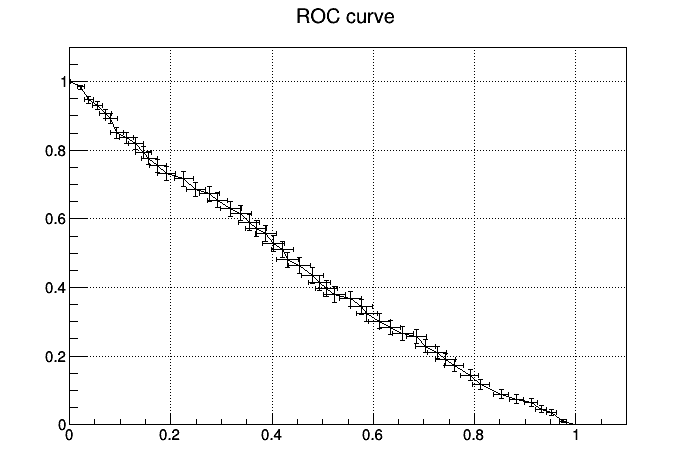

In [15]:
canvas = r.TCanvas("canvas","ROC")
canvas.cd()
canvas.SetGrid()
canvas.GetFrame().SetFillColor(21)
canvas.GetFrame().SetBorderSize(12)

ROC.Draw("ALP")
canvas.Update()
canvas.Draw()

### Plot Matplotlib style

In [16]:
_default_style={
          'plot':{
              'marker':',',
              'mfc':'none',
              'color':'DarkOrange',
              'linestyle':'-'
              },
}

def mplot(ax,x,y,label,yerr=np.nan,xerr=np.nan,style_dict=None):
    if style_dict is None:
        style_dict = _default_style['plot']
    out = ax.errorbar(
          x=x,
          y=y,
          label=label,
          yerr=yerr,
          xerr=xerr,
          **style_dict,
          )

    return out

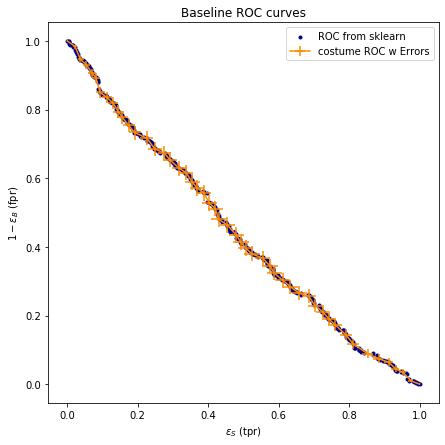

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(7,7)


ax.scatter(x=tpr, y=1-fpr, color='DarkBlue',marker='.',label='ROC from sklearn')
mplot(ax, x, y, label='costume ROC w Errors', yerr=[yEl,yEh], xerr=[xEl,xEh])
ax.set_title('Baseline ROC curves')
ax.set_xlabel(r'$\epsilon_S$ (tpr)')
ax.set_ylabel(r'$1 - \epsilon_B$ (fpr)')
ax.legend()
plt.show()

## Compute AUC with error bars

The idea is to use what we have computed to integrate 3 curves

In [18]:
from sklearn.metrics import roc_auc_score
from scipy.integrate import trapz

first compute  the baseline AUC using standard library

In [20]:
sk_auc = roc_auc_score(y_true=Y_True,y_score=Y_Pred)
print(f'AUC computed with `sklearn.roc_auc_score` = {sk_auc}')

AUC computed with `sklearn.roc_auc_score` = 0.4426287971982577


In [50]:
def compute_AUCwErrorBars(S_Eff_arr, B_Eff_arr,precision=5):
    x, xEl, xEh = S_Eff_arr
    y, yEl, yEh = B_Eff_arr
    
#     auc = trapz(y)
#     auc = trapz(y,x,axis=1)
    x_low = x - xEl
    y_low = y - yEl
    x_high = x + xEh
    y_high = y + yEh
    
    auc = abs(trapz(y,x,axis=0))
    auc_L = trapz(y_low,x_low)
#     print(auc_L)
    auc_H = trapz(y_high,x_high)
#     print(auc_H)
    
    
    LowErr = auc - abs(auc_L)
    HighErr = abs(auc_H) - auc
    
    auc = np.round(auc,precision)
    LowErr = np.round(LowErr,precision)
    HighErr = np.round(HighErr,precision)
    
    return auc, LowErr, HighErr

In [51]:
auc, El, Eh = compute_AUCwErrorBars(SEff, BEff)

print(f'AUC computed with "compute_AUCwErrorBars" = {auc}(-{El},+{Eh})')

-0.4076475089021019
-0.476153298267847
AUC computed with "compute_AUCwErrorBars" = 0.44216(-0.03452,+0.03399)
